In [1]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
import pandas
import pandas as pd


import tensorflow as tf
import tf_data

%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
from tensorflow.keras.callbacks import LearningRateScheduler
import tensorflow_addons as tfa
import json, os
import numpy as np

# Tested with TensorFlow 2.1.0
print('version={}, CUDA={}, GPU={}'.format(
    tf.__version__, tf.test.is_built_with_cuda(),
    len(tf.config.list_physical_devices('GPU')) > 0))
      
if len(tf.config.list_physical_devices('GPU')) > 0:
    physical_devices = tf.config.list_physical_devices('GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
    strategy = tf.distribute.OneDeviceStrategy("gpu:0")
else:
    strategy = tf.distribute.OneDeviceStrategy("cpu:0")

/eos/user/p/psimkina/.local/lib/python3.7/site-packages/tensorflow_addons/utils/ensure_tf_install.py:67: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.5.0 and strictly below 2.8.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.3.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


version=2.3.0, CUDA=True, GPU=True


In [3]:
!nvidia-smi

Mon Feb  7 10:26:41 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64       Driver Version: 440.64       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:07.0 Off |                    0 |
| N/A   60C    P0    29W /  70W |    258MiB / 15109MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Test training

In [4]:
import tf_data_jet
from model import *
from plotting import * 

In [5]:
models_path = "/eos/user/p/psimkina/evaluation/jet_model/MC_binary_genpt_weights/"

#rain_steps_per_epoch = 
#eval_steps_per_epoch = 3e5 // batch_size
from collections import namedtuple
# Args = namedtuple('args', [ 'models_path', 'load','nepochs','ntrain','nval','nfeatures',
#                             'n_seed_features','batch_size','lr_decay','lr',
#                             'hidden_dim_input','hidden_dim_coord', 'hidden_dim_id',
#                             'n_layers_input', 'n_layers_id', 'n_layers_coord',
#                            'distance_dim','num_conv','dropout','convlayer',
#                            'nclass_labels', 'opt'])
Args = namedtuple('args', [ 'models_path', 'load','initial_epoch','nepochs','ntrain','nval',
                           'lr_decay','lr', 'batch_size','opt', 'activation', 
                           'output_dim_rechits', 'output_dim_nodes', 'output_dim_gconv', 'output_dim_sa_clclass',
                           'output_dim_sa_windclass','output_dim_sa_enregr','coord_dim','coord_dim_sa','nconv_rechits','nconv', 
                           'layers_input','layers_clclass','layers_windclass','layers_enregr', 'n_windclasses',
                          'dropout','l2_reg','loss_clusters','loss_window','loss_softF1','loss_en_resol','loss_en_softF1','loss_en_regr','softF1_beta'])


args = Args( 
models_path = models_path,
load = False,
initial_epoch = 0,
nepochs = 200,
ntrain = 900000,
nval = 200000,
lr_decay = 0.,
lr = 3e-3,
batch_size = 512,
opt='adam',
    
activation = tf.keras.activations.elu,
output_dim_rechits = 25,
output_dim_nodes = 256,
output_dim_gconv = 256,
output_dim_sa_clclass = 256,
output_dim_sa_windclass = 256,
output_dim_sa_enregr = 256,
coord_dim = 3,
coord_dim_sa = 15,
nconv_rechits = 4,
nconv = 3,
layers_input = [256,128,128,64],
layers_clclass = [256,128,128,64],
layers_windclass = [128,64,64],
layers_enregr = [256,128,128,64],
n_windclasses = 3, 
dropout = 0.1,
l2_reg = True, 
    
loss_clusters= 0,
loss_window=  1., 
loss_softF1=  0.,
loss_en_resol =  0., 
loss_en_softF1 = 0,
loss_en_regr = 0.,
softF1_beta = 0.
)

### Dataset loading

In [6]:
def get_unique_run():
    previous_runs = os.listdir(args.models_path)
    if len(previous_runs) == 0:
        run_number = 1
    else:
        run_number = max([int(s.split('run_')[1]) for s in previous_runs]) + 1
    return run_number


if not os.path.isdir(args.models_path):
    os.makedirs(args.models_path)

name =  'run_{:02}'.format(get_unique_run())

outdir = args.models_path + name

if os.path.isdir(outdir):
    print("Output directory exists: {}".format(outdir), file=sys.stderr)
else:
    os.makedirs(outdir)

print(outdir)

/eos/user/p/psimkina/evaluation/jet_model/MC_binary_genpt_weights/run_01


In [7]:
data_path_train = {"ele_match": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/electrons/recordio_allinfo_v11/training/calo_matched/*.proto",
                   "gamma_match": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/gammas/recordio_allinfo_v11/training/calo_matched/*.proto",
                   "jet_match": "/eos/user/p/psimkina/SuperClustering/jets_newds/training/calo_matched/*.proto"
                 # "nomatch": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/electrons/recordio_allinfo_v10/training/no_calo_matched/*.proto",
                  #"gamma_nomatch": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/gammas/recordio_allinfo_v2/training/no_calo_matched/*.proto"
                  }
data_path_test = {"ele_match": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/electrons/recordio_allinfo_v11/testing/calo_matched/*.proto",
                   "gamma_match": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/gammas/recordio_allinfo_v11/testing/calo_matched/*.proto",
                  "jet_match": "/eos/user/p/psimkina/SuperClustering/jets_newds/testing/calo_matched/*.proto"
#                   "nomatch": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/electrons/recordio_allinfo_v10/testing/no_calo_matched/*.proto",
                  #"gamma_nomatch": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/gammas/recordio_allinfo_v2/testing/no_calo_matched/*.proto"
                  }

In [8]:
features_dict = {

"cl_features" : [ "en_cluster","et_cluster",
            "cluster_eta", "cluster_phi", 
            "cluster_ieta","cluster_iphi","cluster_iz",
            "cluster_deta", "cluster_dphi",
             "cluster_den_seed","cluster_det_seed",
            
#             "cl_r9", "cl_sigmaIetaIeta", "cl_sigmaIetaIphi",
#             "cl_sigmaIphiIphi","cl_swissCross","cl_etaWidth","cl_phiWidth"
                 
            "cl_nxtals" ],
    

 "window_features" : [ "max_en_cluster","max_et_cluster","max_deta_cluster","max_dphi_cluster","max_den_cluster","max_det_cluster",
                    "min_en_cluster","min_et_cluster","min_deta_cluster","min_dphi_cluster","min_den_cluster","min_det_cluster",
                    "mean_en_cluster","mean_et_cluster","mean_deta_cluster","mean_dphi_cluster","mean_den_cluster","mean_det_cluster" ],

# Metadata about the window like true energy, true calo position, useful info
 "window_metadata" :  ["en_true_sim","et_true_sim", "en_true_gen", "et_true_gen",
                    "en_true_sim_good", "et_true_sim_good",
                    "nclusters_insc",
                    "nVtx", "rho", "obsPU", "truePU",
                    "sim_true_eta", "sim_true_phi",  
                    "en_mustache_raw", "et_mustache_raw","en_mustache_calib", "et_mustache_calib",
                    "event_tot_simen_PU","wtot_simen_PU", "wtot_simen_sig" ]    
}

In [9]:
# Load a balanced dataset from the list of paths given to the function. Selected only the requestes features from clusters and prepare batches
train_ds = tf_data_jet.load_balanced_dataset_batch(data_path_train, features_dict, args.batch_size,weights={"ele_match":0.,"gamma_match":0.5, "jet_match":0.5} )#weights={"ele_match":0.4,"gamma_match":0.4}
# the indexes for energy and et are from the features list we requestes
# train_ds = tf_data.delta_energy_seed(train_ds, en_index=0, et_index=1)
train_ds = tf_data_jet.normalize_features(train_ds, "normalization_v11_all.npz", "normalization_wind_features_v11_all.npz",features_dict['cl_features'], features_dict['window_features'] )
train_ds = tf_data_jet.training_format(train_ds)


test_ds = tf_data_jet.load_balanced_dataset_batch(data_path_test,features_dict, args.batch_size,weights={"ele_match":0.,"gamma_match":0.5, "jet_match":0.5}, training=False)
# the indexes for energy and et are from the features list we requestes
# test_ds = tf_data.delta_energy_seed(test_ds, en_index=0, et_index=1)
test_ds = tf_data_jet.normalize_features(test_ds, "normalization_v11_all.npz", "normalization_wind_features_v11_all.npz",features_dict['cl_features'], features_dict['window_features'])
test_ds = tf_data_jet.training_format(test_ds)

# Create training and validation
ds_train = train_ds.prefetch(300).take(args.ntrain // args.batch_size).cache('training_ds').repeat(args.nepochs)
ds_test  = test_ds.prefetch(300).take(args.nval // args.batch_size).cache('testing_ds').repeat(args.nepochs)

False
False


In [10]:
if args.lr_decay > 0:
        #lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        #    args.lr,
        #    decay_steps=int(args.ntrain//args.batch_size),
        #    decay_rate=args.lr_decay
        #)
        lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
            args.lr,
            decay_steps=int(args.ntrain//args.batch_size),
            decay_rate=args.lr_decay,
            staircase=True
        )
else:
    lr_schedule = args.lr

In [11]:
def get_model(args, weights=None):

    loss_weights = {"clusters":args.loss_clusters, "window":args.loss_window, 
                    "softF1":args.loss_softF1, "en_resol":args.loss_en_resol, "en_softF1":args.loss_en_softF1,"en_regr": args.loss_en_regr, "softF1_beta":args.softF1_beta}
    tf.keras.backend.clear_session()

    
    with strategy.scope():
        opt = tf.keras.optimizers.Adam(learning_rate=args.lr)
        # Construction of the model
        model = DeepClusterGN(
                    activation = args.activation,
                    output_dim_rechits = args.output_dim_rechits,
                    output_dim_nodes =args.output_dim_nodes,
                    output_dim_gconv = args.output_dim_gconv,
                    output_dim_sa_clclass = args.output_dim_sa_clclass,
                    output_dim_sa_windclass = args.output_dim_sa_windclass,
                    output_dim_sa_enregr = args.output_dim_sa_enregr,
                    coord_dim = args.coord_dim,
                    coord_dim_sa = args.coord_dim_sa,
                    nconv_rechits = args.nconv_rechits,
                    nconv = args.nconv,
                    layers_input = args.layers_input,
                    layers_clclass = args.layers_clclass,
                    layers_windclass = args.layers_windclass,
                    layers_enregr = args.layers_enregr,
                    n_windclasses = args.n_windclasses,
                    dropout = args.dropout,
                    l2_reg = args.l2_reg,
                    loss_weights= loss_weights
                    )


        model.compile(optimizer=args.opt)
    #         metrics=[Precision(),Recall(), energy_resolution|_insc,energy_resolution_outsc,
    #                      energy_resolution_insc_log,energy_resolution_outsc_log,])
        model.set_metrics()

        for X, y, w in ds_train:
            #print(w)
            ypred = model(X)
            #l = custom_loss(y, ypred)
            break
        
        if weights:
            model.load_weights(weights)
        
        return model

In [12]:
model = get_model(args)
model.load_weights("/eos/user/d/dvalsecc/www/ECAL/Clustering/DeepCluster/models_archive/gcn_models/photonselectrons_largemodel/run_03/weights.best.hdf5")

In [13]:
model.summary()

Model: "deep_cluster_gn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
graph_builder (GraphBuilding multiple                  96123     
_________________________________________________________________
GHN_global (GHConvI)         multiple                  131328    
_________________________________________________________________
SA_clclass (SelfAttentionBlo multiple                  394752    
_________________________________________________________________
dense_clclass (Sequential)   (512, 28, 1)              189057    
_________________________________________________________________
SA_windclass (SelfAttentionB multiple                  656896    
_________________________________________________________________
dense_windclass (Sequential) (512, 3)                  47811     
_________________________________________________________________
SA_enregr (SelfAttentionBloc multiple              

In [14]:
for layers in model.layers: 
    layers.trainable = False

In [15]:
model.summary()

Model: "deep_cluster_gn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
graph_builder (GraphBuilding multiple                  96123     
_________________________________________________________________
GHN_global (GHConvI)         multiple                  131328    
_________________________________________________________________
SA_clclass (SelfAttentionBlo multiple                  394752    
_________________________________________________________________
dense_clclass (Sequential)   (512, 28, 1)              189057    
_________________________________________________________________
SA_windclass (SelfAttentionB multiple                  656896    
_________________________________________________________________
dense_windclass (Sequential) (512, 3)                  47811     
_________________________________________________________________
SA_enregr (SelfAttentionBloc multiple              

In [16]:
model.SA_windclass.trainable = True
model.dense_windclass.trainable = True
model.SA_windclass_layernorm.trainable = True

In [17]:
model.summary()

Model: "deep_cluster_gn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
graph_builder (GraphBuilding multiple                  96123     
_________________________________________________________________
GHN_global (GHConvI)         multiple                  131328    
_________________________________________________________________
SA_clclass (SelfAttentionBlo multiple                  394752    
_________________________________________________________________
dense_clclass (Sequential)   (512, 28, 1)              189057    
_________________________________________________________________
SA_windclass (SelfAttentionB multiple                  656896    
_________________________________________________________________
dense_windclass (Sequential) (512, 3)                  47811     
_________________________________________________________________
SA_enregr (SelfAttentionBloc multiple              

In [18]:
model.compile(optimizer=args.opt)

In [19]:
callbacks = []
tb = tf.keras.callbacks.TensorBoard(
    log_dir=outdir, histogram_freq=2, 
    write_graph=False, 
    write_images=True,
    update_freq='epoch',
    profile_batch=0,
)
tb.set_model(model)
callbacks += [tb]

terminate_cb = tf.keras.callbacks.TerminateOnNaN()
callbacks += [terminate_cb]

lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, verbose=1,
    mode='auto', min_delta=0.0005, cooldown=0, min_lr=1e-7,
)


cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=outdir + "/weights.{epoch:02d}-{val_loss:.6f}.hdf5",
    save_weights_only=True,
    verbose=1
)
cp_callback.set_model(model)


early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0.001, patience=20, verbose=1,
    mode='auto', baseline=None, restore_best_weights=False
)
early.set_model(model)


import plot_loss

loss_plotter = plot_loss.LossPlotter(outdir)
# loss_plotter.set_model(model)


callbacks += [loss_plotter, cp_callback, lr_reduce, early]



In [20]:
with open(outdir + "/args.txt",'w') as config:
    config.write(str(args))

conf = [ 'models_path', 'load','initial_epoch','nepochs','ntrain','nval',
                           'lr_decay','lr', 'batch_size','opt', 'activation', 
                           'output_dim_rechits', 'output_dim_nodes', 'output_dim_gconv', 'output_dim_sa_clclass',
                           'output_dim_sa_windclass','output_dim_sa_enregr','coord_dim','coord_dim_sa','nconv_rechits','nconv', 
                           'layers_input','layers_clclass','layers_windclass','layers_enregr', 'n_windclasses',
                          'dropout','l2_reg','loss_clusters','loss_window','loss_softF1','loss_en_resol','loss_en_softF1','loss_en_regr']

configs = {}
for c in conf:
    if c == 'activation': configs[c] = "elu"
    else: configs[c] = getattr(args, c)
        
configs["features_dict"] = features_dict
configs["data_path"] = data_path_train
configs["normalizations "] = [ "normalization_v11_noshowershapes.npz", "normalization_wind_features_v11_noshowershapes.npz"]
    
import json
json.dump(configs, open(outdir + "/args_load.json","w"), indent=2)

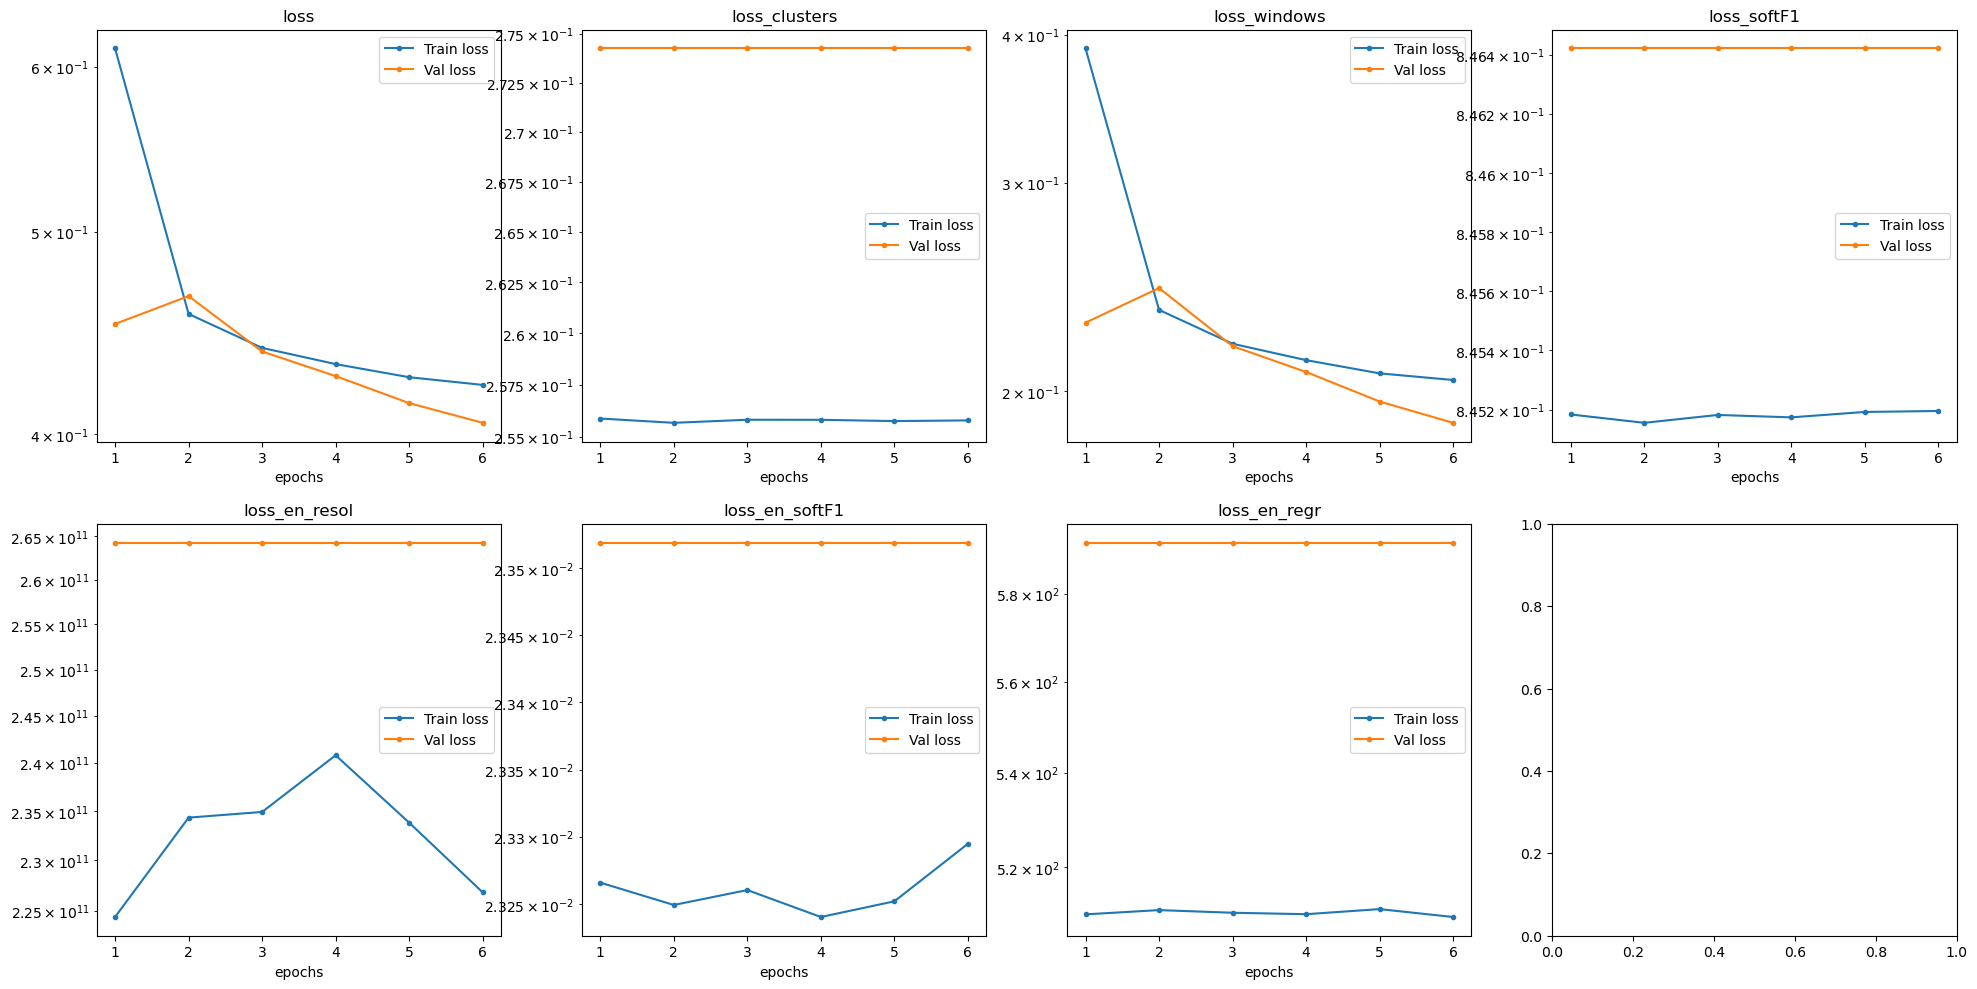


Epoch 00006: saving model to /eos/user/p/psimkina/evaluation/jet_model/MC_binary_genpt_weights/run_01/weights.06-0.405161.hdf5
1757/1757 [==============================] - 319s 181ms/step - loss: 0.4225 - loss_clusters: 0.2558 - loss_windows: 0.2044 - loss_softF1: 0.8452 - loss_en_resol: 226824355840.0000 - loss_en_softF1: 0.0233 - loss_en_regr: 509.7646 - val_loss: 0.4052 - val_loss_clusters: 0.2743 - val_loss_windows: 0.1881 - val_loss_softF1: 0.8464 - val_loss_en_resol: 264246378496.0000 - val_loss_en_softF1: 0.0235 - val_loss_en_regr: 591.9742
Epoch 7/200
 222/1757 [==>...........................] - ETA: 4:24 - loss: 0.3602 - loss_clusters: 0.3059 - loss_windows: 0.1435 - loss_softF1: 0.8476 - loss_en_resol: 404591443968.0000 - loss_en_softF1: 0.0245 - loss_en_regr: 783.8220

In [ ]:
if args.nepochs > 0:
    ret = model.fit(ds_train,
        validation_data=ds_test, 
        epochs=args.nepochs,
        steps_per_epoch= args.ntrain//args.batch_size, 
        validation_steps= args.nval//args.batch_size,
        verbose=True,
        callbacks = callbacks,
        initial_epoch = args.initial_epoch
    )